# Импорт библиотек

In [38]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import logging
from comet_ml import Experiment

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Настройка CometML

In [39]:
# создание эксперимента
experiment = Experiment(
    api_key="GahJ5CR64w0pqfgRkemOzX8UH",
    project_name="medical-appointment",
    workspace="royvudgren",
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/royvudgren/medical-appointment/5c48766994c6491882521f723f6e4dce
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 2
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/royvudgren/medical-appointment/4b007c955d674ca6a244f7ffed3fb40d



# Загрузка данных

In [40]:
# загрузка датафрейма
df = pd.read_csv('data/KaggleV2-May-2016.csv')

In [41]:
df.head()

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

# Визуализация

### Распределение числовых признаков

{'web': 'https://www.comet.com/api/image/download?imageId=dc4d1285c1374759b4d0fa83155ed3a5&experimentKey=4b007c955d674ca6a244f7ffed3fb40d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=dc4d1285c1374759b4d0fa83155ed3a5&experimentKey=4b007c955d674ca6a244f7ffed3fb40d',
 'imageId': 'dc4d1285c1374759b4d0fa83155ed3a5'}

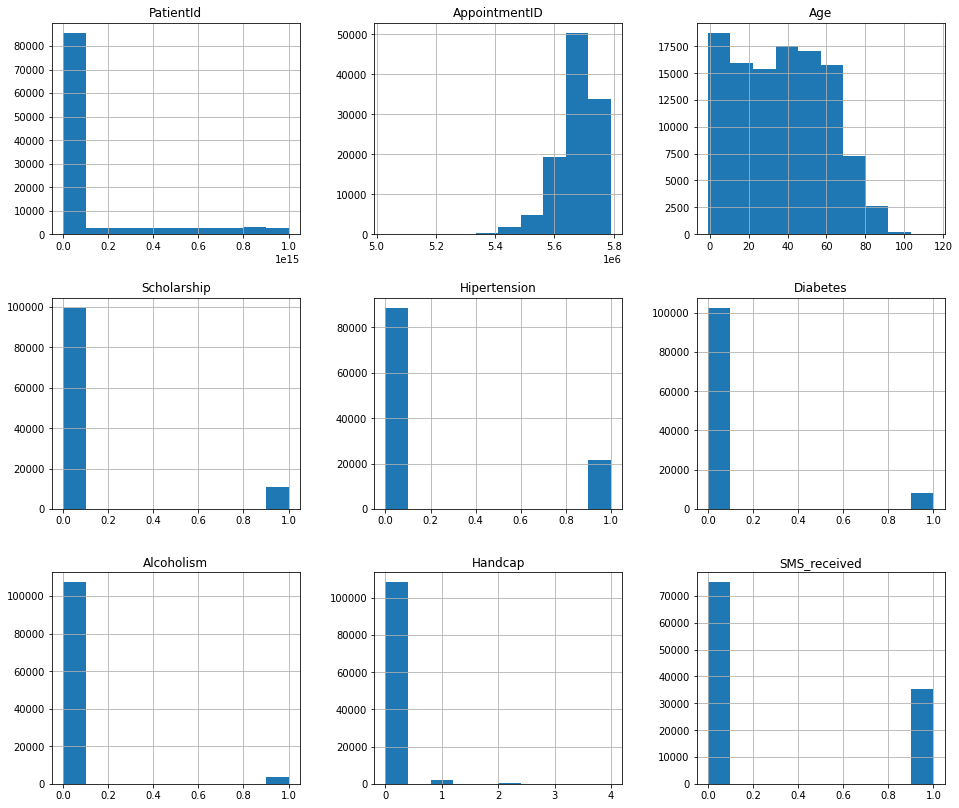

In [42]:
df.hist(figsize=(16,14));
#логируем гистограмму
experiment.log_figure(figure=plt)

*Проанализируем число людей каждого возраста*

In [43]:
print("Уникальные значения в `Age` => {}".format(df.Age.unique()))

Уникальные значения в `Age` => [ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35  20
  26  34  33  16  42   5  47  17  41  44  37  24  66  77  81  70  53  75
  73  52  74  43  89  57  14   9  48  83  72  25  80  87  88  84  82  90
  94  86  91  98  92  96  93  95  97 102 115 100  99  -1]


In [44]:
# Удалим аномальные значения
df = df[(df.Age >= 0) & (df.Age <= 110)]
df.Age.value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
97       11
98        6
100       4
102       2
99        1
Name: Age, Length: 102, dtype: int64

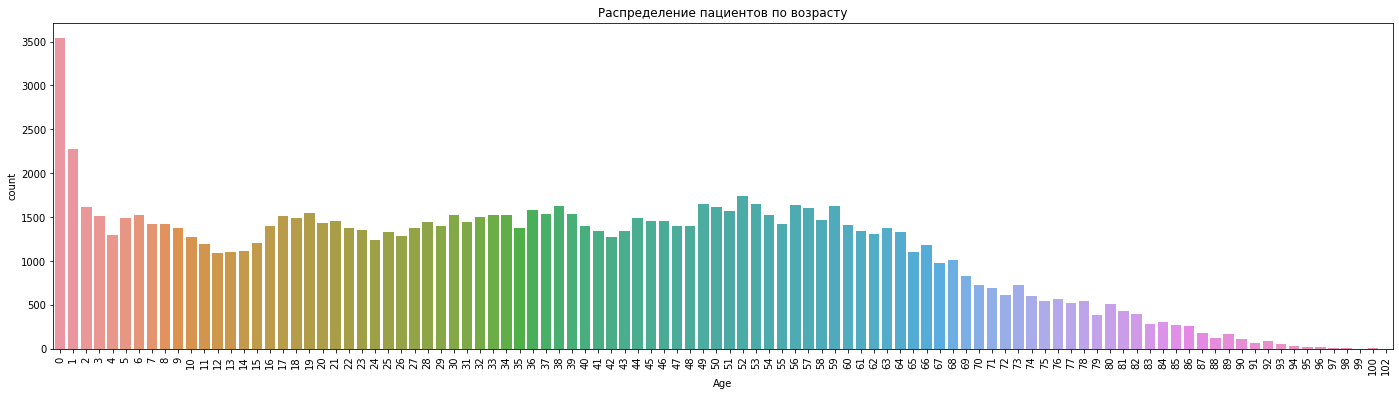

In [45]:
plt.figure(figsize=(24,6))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age)
ax.set_title("Распределение пациентов по возрасту")
experiment.log_figure(figure=plt)
plt.show()

# Придет ли пациент на назначенный приём? 

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110521 non-null  float64
 1   AppointmentID   110521 non-null  int64  
 2   Gender          110521 non-null  object 
 3   ScheduledDay    110521 non-null  object 
 4   AppointmentDay  110521 non-null  object 
 5   Age             110521 non-null  int64  
 6   Neighbourhood   110521 non-null  object 
 7   Scholarship     110521 non-null  int64  
 8   Hipertension    110521 non-null  int64  
 9   Diabetes        110521 non-null  int64  
 10  Alcoholism      110521 non-null  int64  
 11  Handcap         110521 non-null  int64  
 12  SMS_received    110521 non-null  int64  
 13  No-show         110521 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 17.6+ MB


## Кодировка категориальных признаков

In [47]:
categorical_columns_names = ['Gender', 'Neighbourhood']

In [48]:
encoded_columns = pd.get_dummies(df, columns = categorical_columns_names)

In [49]:
encoded_columns.drop(['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay', 'No-show'], axis=1, inplace = True)

In [50]:
encoded_columns.head()

Age  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0   62            0             1         0           0        0   
1   56            0             0         0           0        0   
2   62            0             0         0           0        0   
3    8            0             0         0           0        0   
4   56            0             1         1           0        0   

   SMS_received  Gender_F  Gender_M  Neighbourhood_AEROPORTO  ...  \
0             0         1         0                        0  ...   
1             0         0         1                        0  ...   
2             0         1         0                        0  ...   
3             0         1         0                        0  ...   
4             0         1         0                        0  ...   

   Neighbourhood_SANTOS REIS  Neighbourhood_SEGURANÇA DO LAR  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

   Neighbourhood_SOLON BORGES  Neighbourhood_SÃO BENEDITO  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   Neighbourhood_SÃO CRISTÓVÃO  Neighbourhood_SÃO JOSÉ  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   Neighbourhood_SÃO PEDRO  Neighbourhood_TABUAZEIRO  \
0                        0                         0   
1                        0                         0   
2                        0                         0   
3                        0                         0   
4                        0                         0   

   Neighbourhood_UNIVERSITÁRIO  Neighbourhood_VILA RUBIM  
0                            0                         0  
1                            0                         0  
2                            0                         0  
3                            0                         0  
4                            0                         0  

[5 rows x 90 columns]

In [51]:
y = df['No-show']

In [52]:
y

0         No
1         No
2         No
3         No
4         No
          ..
110522    No
110523    No
110524    No
110525    No
110526    No
Name: No-show, Length: 110521, dtype: object

In [53]:
y = y.replace({'No': 0, 'Yes': 1})

In [54]:
y.value_counts(True)

0    0.798084
1    0.201916
Name: No-show, dtype: float64

## Шкалирование данных

In [55]:
scaler = MinMaxScaler()
X = scaler.fit_transform(encoded_columns)

In [56]:
print(X.shape)

(110521, 90)


# Модель (этот раздел будет подробно изучен далее в курсе)

### Инициализация модели

In [57]:
logreg = LogisticRegression()

In [58]:
random_state = 42

### Обучение модели

In [59]:
logreg.fit(X, y)

c:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Логирование параметров обучения

In [60]:
params={"random_state":random_state,
        "model_type":"logreg"
}

In [61]:
experiment.log_parameters(params)

### Предсказания модели

In [62]:
y_pred = logreg.predict(X)

### Анализ модели

In [63]:
accuracy = accuracy_score(y, y_pred)

print("Доля правильных ответов: {:6.3f}".format(accuracy))

Доля правильных ответов:  0.798


# Логирование метрик

In [64]:
metrics = {"accuracy":accuracy}

In [65]:
experiment.log_metrics(metrics)

<img src = 'https://miro.medium.com/max/1400/0*r2yYhe2DpE4d3WKP.png' width=700px>

In [66]:
experiment.log_confusion_matrix(y.tolist(), y_pred.tolist())

{'web': 'https://www.comet.com/api/asset/download?assetId=d3a0d4c629ec4d65b051cdd5a9046fdf&experimentKey=4b007c955d674ca6a244f7ffed3fb40d',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d3a0d4c629ec4d65b051cdd5a9046fdf&experimentKey=4b007c955d674ca6a244f7ffed3fb40d',
 'assetId': 'd3a0d4c629ec4d65b051cdd5a9046fdf'}

In [67]:
experiment.display()

# Домашнее задание

Визуализируйте корреляцию между числовыми признаками, использованными для обучения модели и залогируйте изображение в Comet.

В качестве ответа приложите обновленный ноутбук.

*Форма оценки ментором:*

1) Проведена визуализация корреляции между 7 числовыми признаками, использованными для обучения модели - 5 баллов

2) Произведено логирование графика в CometMl - 10 баллов



**ПОДГОТОВКА ДАННЫХ**

In [68]:
# перезагрузка датафрейма
df = pd.read_csv('data/KaggleV2-May-2016.csv')

# удаляем столбцы с айди (не участвующие в обучении)
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
# удаляем выбросы по возрасту
df = df[(df.Age >= 0) & (df.Age <= 110)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Gender          110521 non-null  object
 1   ScheduledDay    110521 non-null  object
 2   AppointmentDay  110521 non-null  object
 3   Age             110521 non-null  int64 
 4   Neighbourhood   110521 non-null  object
 5   Scholarship     110521 non-null  int64 
 6   Hipertension    110521 non-null  int64 
 7   Diabetes        110521 non-null  int64 
 8   Alcoholism      110521 non-null  int64 
 9   Handcap         110521 non-null  int64 
 10  SMS_received    110521 non-null  int64 
 11  No-show         110521 non-null  object
dtypes: int64(7), object(5)
memory usage: 11.0+ MB


**МАТРИЦА КОРРЕЛЯЦИЙ**

Age  Scholarship  Hipertension  Diabetes  Alcoholism  \
Age           1.000000    -0.092437      0.504726  0.292509    0.095862   
Scholarship  -0.092437     1.000000     -0.019731 -0.024899    0.035019   
Hipertension  0.504726    -0.019731      1.000000  0.433096    0.087972   
Diabetes      0.292509    -0.024899      0.433096  1.000000    0.018471   
Alcoholism    0.095862     0.035019      0.087972  0.018471    1.000000   
Handcap       0.077369    -0.008520      0.080249  0.057629    0.004689   
SMS_received  0.012676     0.001188     -0.006309 -0.014555   -0.026151   

               Handcap  SMS_received  
Age           0.077369      0.012676  
Scholarship  -0.008520      0.001188  
Hipertension  0.080249     -0.006309  
Diabetes      0.057629     -0.014555  
Alcoholism    0.004689     -0.026151  
Handcap       1.000000     -0.024026  
SMS_received -0.024026      1.000000

{'web': 'https://www.comet.com/api/image/download?imageId=b1b0036fc5904791bc11a784214dc8ec&experimentKey=4b007c955d674ca6a244f7ffed3fb40d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b1b0036fc5904791bc11a784214dc8ec&experimentKey=4b007c955d674ca6a244f7ffed3fb40d',
 'imageId': 'b1b0036fc5904791bc11a784214dc8ec'}

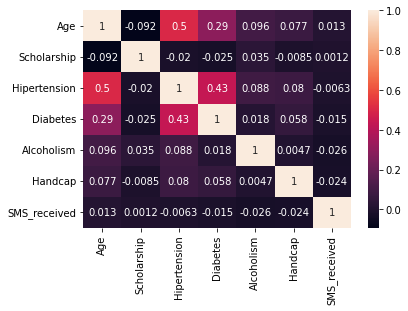

In [69]:
# матрица корреляций числовых признаков
display(df.corr())

# тепловая карта корреляций
ax = sns.heatmap(df.corr(), annot = True);
# логирование графика
experiment.log_figure('Heatmap_corr')

**КОМЕТ-ДИСПЛЕЙ**

In [70]:
experiment.display()

**КОНЕЦ ЭКСПЕРИМЕНТА**

In [71]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/royvudgren/medical-appointment/4b007c955d674ca6a244f7ffed3fb40d
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.7980836221170637
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : 1
COMET INFO:     clip              : False
COMET INFO:     copy              : True
COMET INFO:     dual              : False
COMET INFO:     feature_range     : (0, 1)
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : 1
COMET INFO:     max_iter          : 100
COMET INFO:     model_type        : logreg
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : 1
COMET INFO:     penalty           : l2
COMET INFO:     random_state     